In [26]:
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geodatasets
import pandas as pd

In [27]:
# Load results from file
with open("privatisation_results.json", "r", encoding="utf-8") as f:
    results = json.load(f)

# Define color mapping
color_map = {
    "no": "green",
    "partly": "yellow",
    "yes": "red"
}

# Load a world shapefile from Natural Earth via GeoPandas
# 3) Load Natural Earth 1:50m countries directly from URL (works with GeoPandas/GDAL)
NE50_COUNTRIES_URL = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_50m_admin_0_countries.geojson"
world = gpd.read_file(NE50_COUNTRIES_URL)

# Natural Earth uses uppercase field names; CONTINENT + ADMIN are reliable
# Filter to Europe (by Natural Earth's continent field)
europe = world[world["CONTINENT"] == "Europe"].copy()

# Add turkey and syria
turkey = world[world["ADMIN"] == "Turkey"].copy()
syria = world[world["ADMIN"] == "Syria"].copy()
europe = pd.concat([europe, turkey, syria], ignore_index=True)

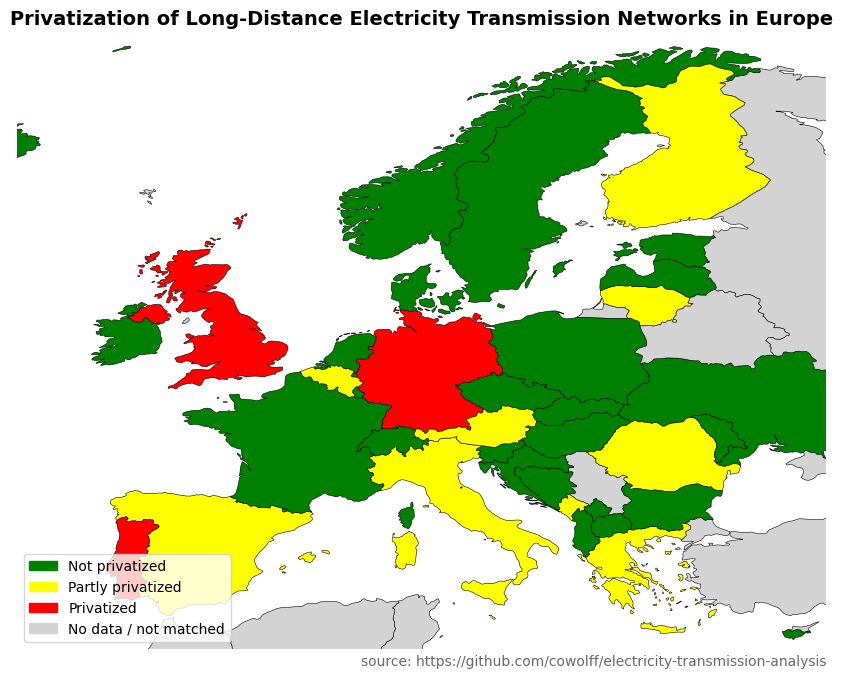

In [42]:
name_alias = {
    "Czechia": "Czech Republic",  # some NE versions still say Czech Republic
    "North Macedonia": "Macedonia",
    "Slovakia": "Slovak Republic",
    "United Kingdom": "United Kingdom",
    "Kosovo": None,               # not in many NE country layers
    "Turkey": "Turkey",           # transcontinental; remains in Europe via CONTINENT==Europe? (usually Asia)
    "Georgia": "Georgia",         # transcontinental; NE might classify as Asia (so may be filtered out)
    "Azerbaijan": "Azerbaijan",   # same note as Georgia
}

# Build reverse aliases: map NE 'ADMIN' back to your results keys
reverse_alias = {v: k for k, v in name_alias.items() if v}

def pick_color(admin_name: str) -> str:
    # Resolve your-country-key from NE admin name
    # 1) direct match
    if admin_name in results:
        key = admin_name
    # 2) via reverse alias
    elif admin_name in reverse_alias:
        key = reverse_alias[admin_name]
    else:
        # 3) try a few lenient fallbacks
        #    (normalize accents/punctuation as needed—kept simple here)
        key = None
        if admin_name == "Russian Federation" and "Russia" in results:
            key = "Russia"
        elif admin_name == "Côte d’Ivoire" and "Cote d'Ivoire" in results:
            key = "Cote d'Ivoire"

    if key and key in results and results[key].get("privatized") in color_map:
        return color_map[results[key]["privatized"]]
    return "lightgrey"  # no data / mismatch

# Apply colors
world["color"] = world["ADMIN"].apply(pick_color)

# 5) Plot
fig, ax = plt.subplots(figsize=(11, 8))
world.plot(color=world["color"], edgecolor="black", linewidth=0.4, ax=ax)

legend_patches = [
    mpatches.Patch(color="green", label="Not privatized"),
    mpatches.Patch(color="yellow", label="Partly privatized"),
    mpatches.Patch(color="red", label="Privatized"),
    mpatches.Patch(color="lightgrey", label="No data / not matched"),
]
# Zoom to Europe (lon/lat bounding box)
ax.set_xlim(-15, 35)   # west-east
ax.set_ylim(34, 72)    # south-north
ax.legend(handles=legend_patches, loc="lower left")
ax.set_title("Privatization of Long-Distance Electricity Transmission Networks in Europe", fontsize=14, fontweight="bold")
ax.text(
    1.0, -0.02,
    "source: https://github.com/cowolff/electricity-transmission-analysis",
    ha="right", va="center", fontsize=10, color="dimgray",
    transform=ax.transAxes
)
ax.axis("off")
plt.show()